# Machine Learning task: Predicting response to cancer immunotherapy
by: __Pawel Rosikiewicz__ www.SimpleAI.ch   
provided by: __Ardigen__  

## __Intro__
---

### __Bacground__
In [cancer immunotherapy](https://en.wikipedia.org/wiki/Cancer_immunotherapy), the patient’s immune system is stimulated to destroy tumor cells, which has proven effective in numerous indications. However, only 20-40% of patients respond to immunotherapy and one of the challenges in cancer research is to predict which patients will be responders.
 
### __Data__   
A dataset related to patients who underwent cancer immunotherapy is provided with patients’ clinical information, RNA sequencing data, and response status.    
Datasets for model training are available in the tab-separated values (.tsv) format
* X_covariates.tsv - clinical information for all patients
* X_genes.tsv - normalized RNA-sequencing data (TPM values for 31085 genes) 
* y.tsv - response status of patients (1-responder, 0-non-responder)
Datasets for model evaluation (test set):
•	X_covariates_test.tsv 
•	X_genes_test.tsv
Note: information for patients in all datasets is provided in a row-wise manner (1 row per patient).

## __Task Description__   
* to build a model predicting the patient’s probability of response to immunotherapy. 

### __Evaluatiosn and success criteria__
We will evaluate your approach to this modeling task based on: 
* a. the description (e.g. justification of decisions made during modeling, interpretation of intermediate results), cleanness, and overall quality of your solution
* b. the performance of your model evaluated on an independent test set and measured with ROC AUC. 

You are expected to provide a document (e.g. a jupyter notebook) demonstrating your approach to data analysis, data modeling, and model evaluation. The analysis should be done in Python. At the end of the document please generate predictions, i.e. probabilities of the patient being a responder/non-responder, for patients from the test set. Please save these probabilities into a separate file y_preds.tsv. Optionally (as a bonus task) you can provide a simple application for scoring patients. The application, given a file with patient’s data, outputs prediction (probability of response).

What performance (ROC AUC in what range) do you expect on the test set based on your analysis?
 
Description of some of the columns in X_covariates.tsv:


## setup

In [1]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)
print(basedir) # shoudl be ../<myproject>/

/Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen


In [3]:
# load custom functions
from src.utils import DataFrameExplorer_summary as dfe # my old package to explore data in df, 

In [4]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

## EDA
---

load patient data and evaluate them

In [5]:
# Load to DataFrame
def load_tsv(path, file_name, verbose=True):
    '''helper function to load tsv files in my data structure
       . path - str, full path to file
       . file_name - str, full file name, wiht extension
    '''
    df = pd.read_csv(os.path.join(path, file_name),sep='\t')
    if verbose==True:
        print(df.shape)
    else:
        pass
    return df


# load target data
data_cov =  load_tsv(PATH_data_raw, 'X_covariates.tsv')
data_genes = load_tsv(PATH_data_raw, 'X_genes.tsv')
target = load_tsv(PATH_data_raw, 'y.tsv')

(200, 17)
(200, 31085)
(199, 1)


create summary with my custom function

In [6]:
# fonfig file
configs_barPlot= dict(adjust_top=0.95, fontsize_scale=1.2, barplot_cmap="tab10") # for annotated_barplot
configs_pieChart = dict(class_colors_cmap="tab10", title="Column number with each data type", cmap_colors_from=0,
                        cmap_colors_to=0.3, figsze_scale=1, figwidth_scale=0.6, figheight_scale=0.6, subplots_adjust_top=0.98,
                        title_fontsize_scale=0.5, ax_title_fonsize_scale=0.5, title_ha='center') # annotated_pie_chart_with_class_and_group



In [10]:
data_cov = pd.concat([data_cov, target], axis=1)
data_cov.shape()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

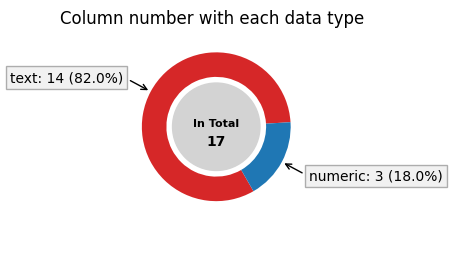

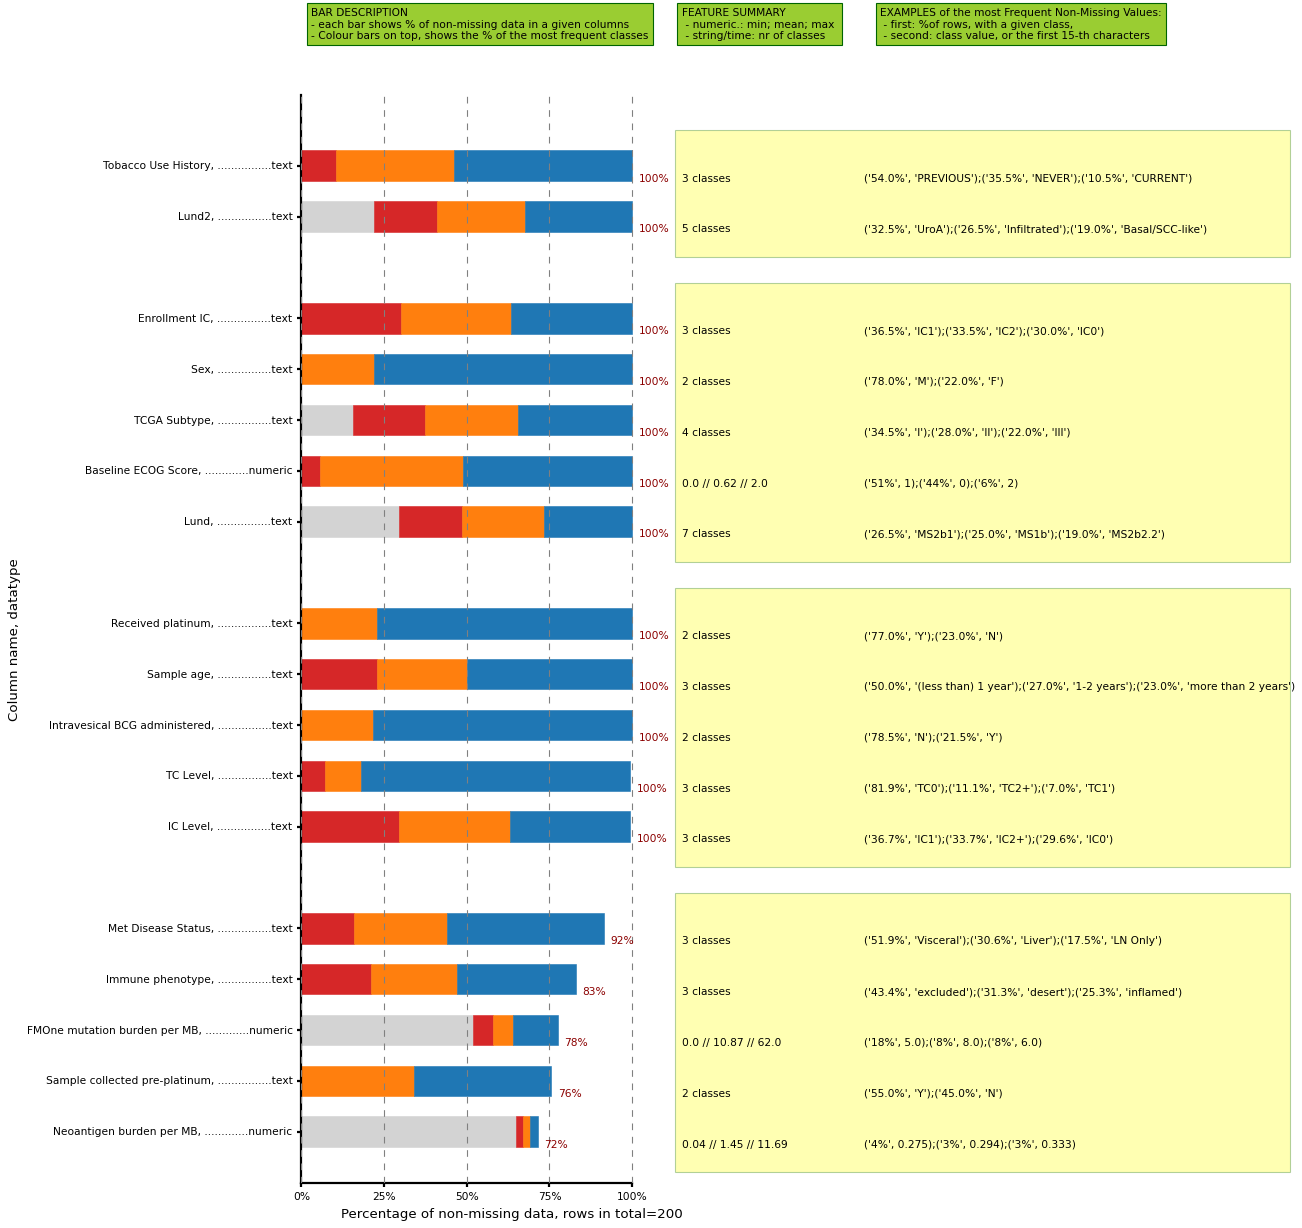

In [7]:
# check for missing data , and examples in each variable
dfe.df_summary_plot(
    df=data_cov,pieChart = True, showTable = False, barPlot =True,
    barPlot_dct = configs_barPlot, pieChart_dct = configs_pieChart) 

show examples of missing data

In [49]:
data_cov.loc[data_cov['Neoantigen burden per MB'].isnull(),:].head()

,FMOne mutation burden per MB,Neoantigen burden per MB,Enrollment IC,IC Level,TC Level,Immune phenotype,Sex,TCGA Subtype,Lund,Lund2,Received platinum,Met Disease Status,Sample age,Sample collected pre-platinum,Intravesical BCG administered,Baseline ECOG Score,Tobacco Use History
4,10.0,NaN,IC1,IC1,TC0,desert,M,IV,MS2b1,Infiltrated,Y,Visceral,(less than) 1 year,NaN,N,1,PREVIOUS
5,14.0,NaN,IC1,IC1,TC0,inflamed,M,II,MS2a2,Genomically unstable,Y,Visceral,(less than) 1 year,Y,N,0,PREVIOUS
7,8.0,NaN,IC2,IC2+,TC0,desert,M,IV,MS2b2.1,UroB,Y,Visceral,(less than) 1 year,N,N,1,PREVIOUS
15,NaN,NaN,IC0,IC0,TC0,desert,M,I,MS2b2.1,UroB,Y,Visceral,1-2 years,N,Y,0,CURRENT
17,12.0,NaN,IC0,IC0,TC0,NaN,M,I,MS1b,UroA,Y,Visceral,(less than) 1 year,N,Y,1,NEVER


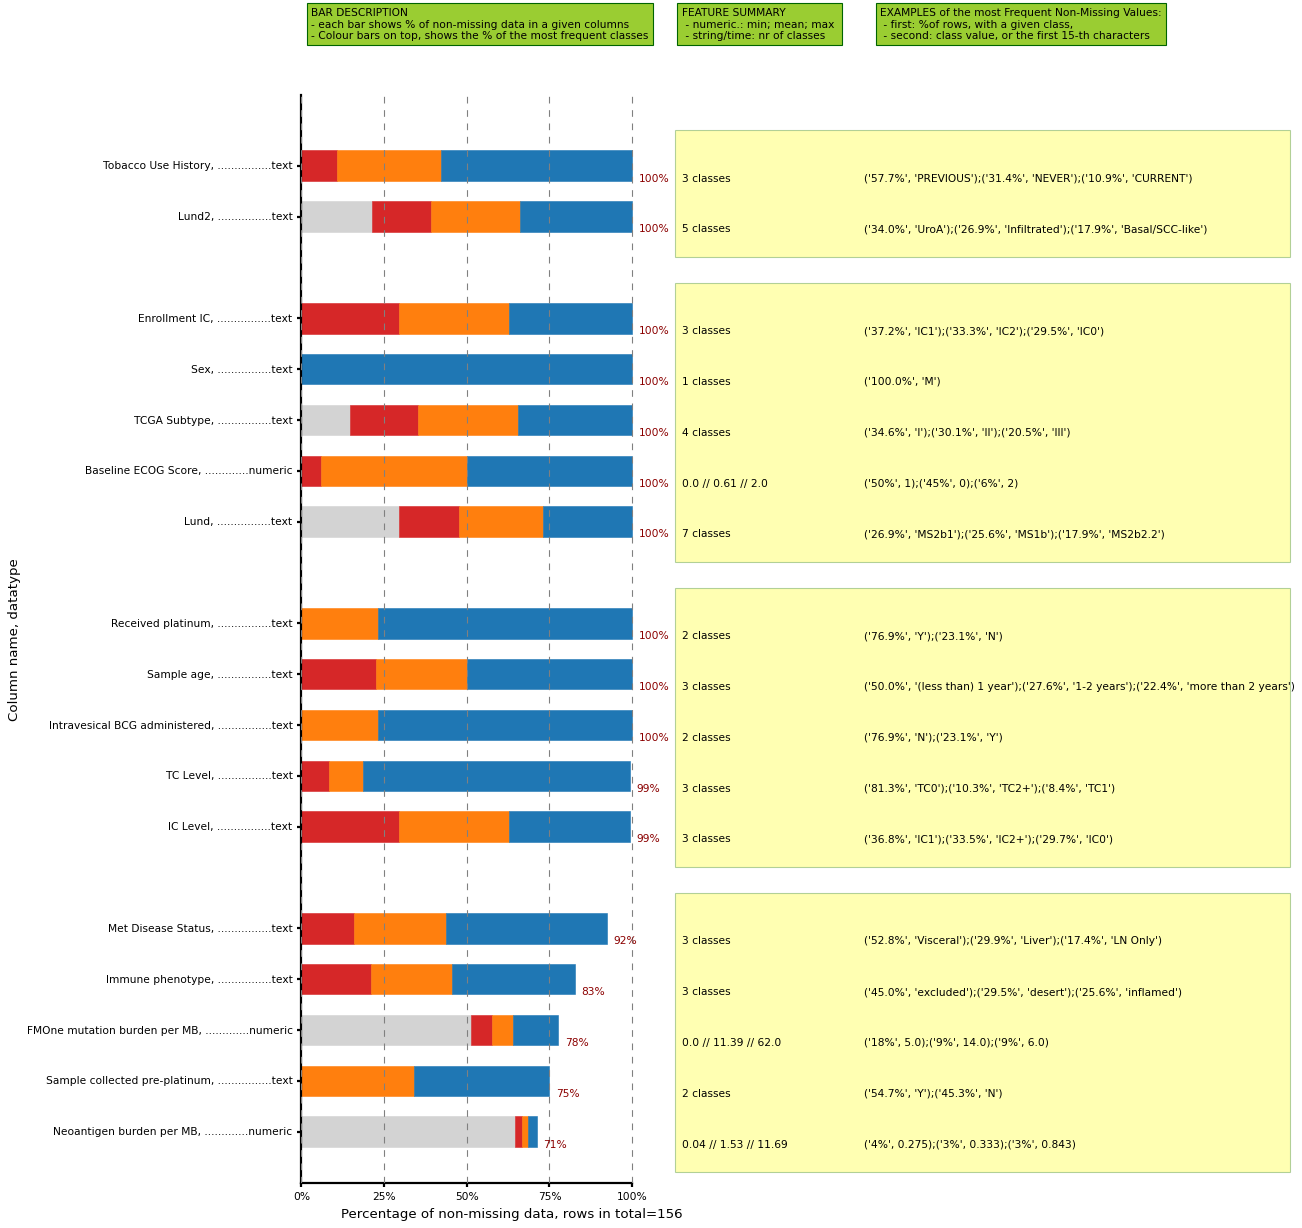

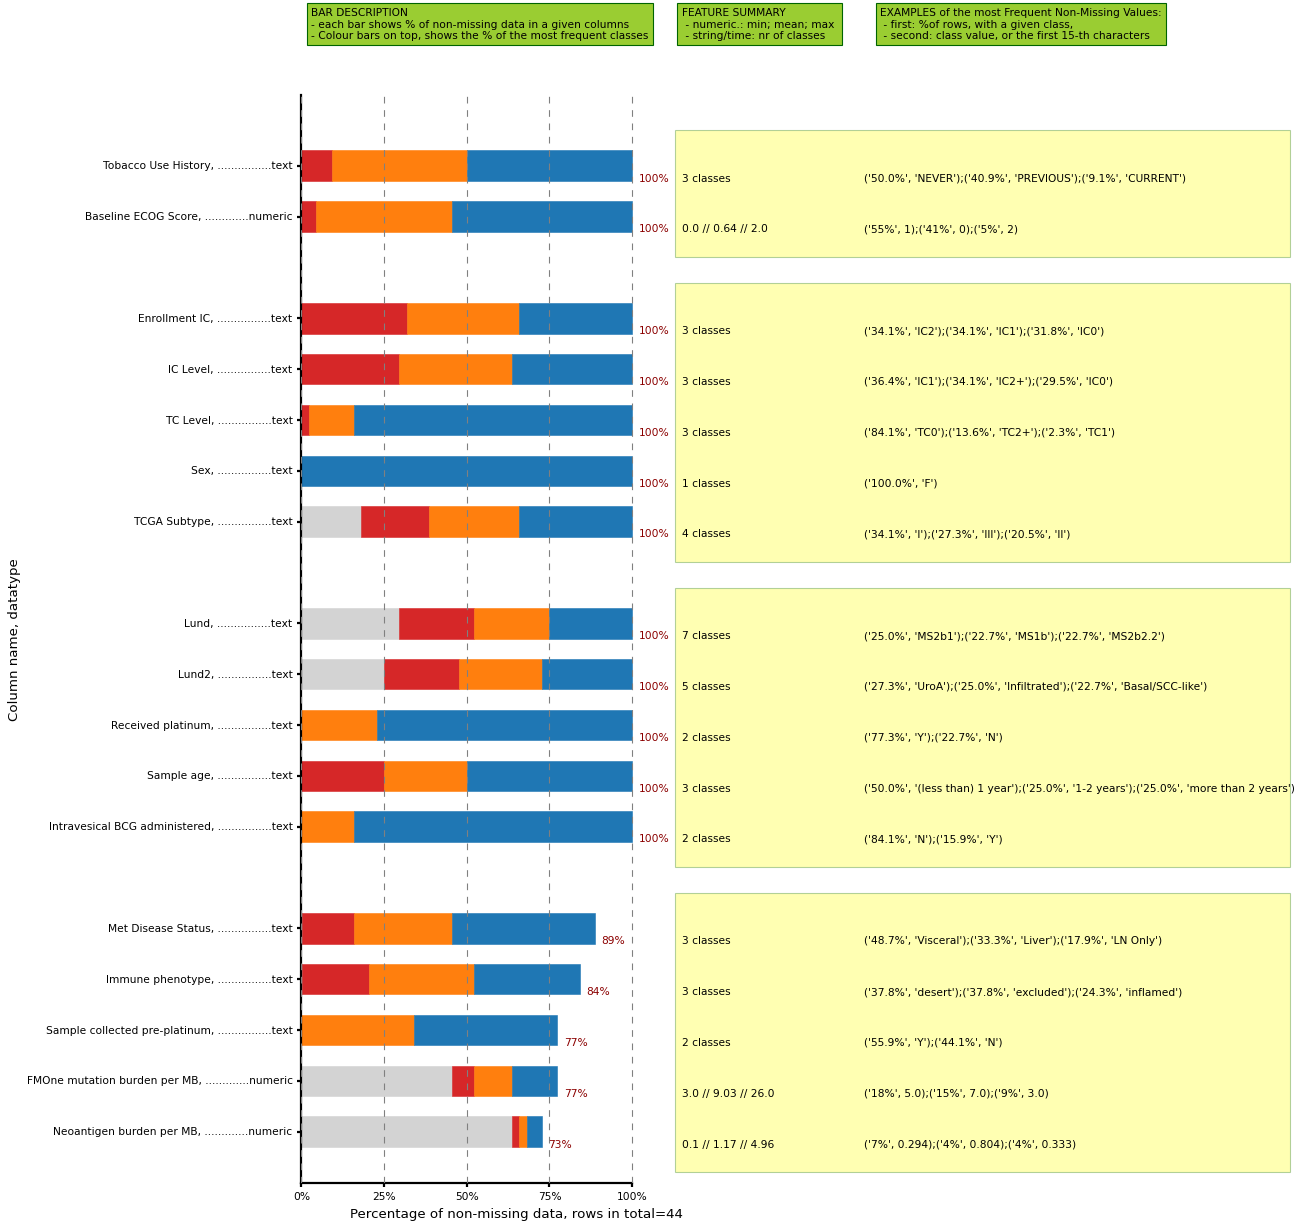

In [53]:
# check for missing data , and examples in each variable
dfe.df_summary_plot(
    df=data_cov.loc[data_cov['Sex']=="M",:],
    pieChart = False, showTable = False, barPlot =True,
    barPlot_dct = configs_barPlot, pieChart_dct = configs_pieChart) 

dfe.df_summary_plot(
    df=data_cov.loc[data_cov['Sex']=="F",:],
    pieChart = False, showTable = False, barPlot =True,
    barPlot_dct = configs_barPlot, pieChart_dct = configs_pieChart) 



In [72]:
df = data_cov
fname = "Sex"
unique_labels = df[fname].unique().tolist()

# stack array subsets on top of each other, and modify index names
for i, label in enumerate(unique_labels):
    if i==0:
        df_tall = df.loc[df[fname]==label,:]
    else:
        df_tall = pd.concat([df_tall, df.loc[df[fname]==label,:]])
        
    print(df_tall.shape)



(156, 17)
(200, 17)


In [139]:
   
# Function, ............................................................................    
def simplified_df_summary_plot(*, 
    df,
    fname,
    top_n=3,
    fig_size=(8,6),
    groupSize=2,
    barPlot_dct=dict(),
    verbose=False                     
):
    # global settings - legacy code, 
    add_all_groups=True
    
    # find unique class labels in a feature
    unique_labels = df[fname].unique().tolist()
    
    return  unique_labels   
    
# check for missing data , and examples in each variable
unique_labels= simplified_df_summary_plot(
    df=data_cov,
    fname="Immune phenotype",
    fig_size=(20,8),
    barPlot_dct=configs_barPlot) 




In [147]:
pd.Series(unique_labels).loc[pd.Series(unique_labels).isnull()==False].tolist()

['inflamed', 'desert', 'excluded']

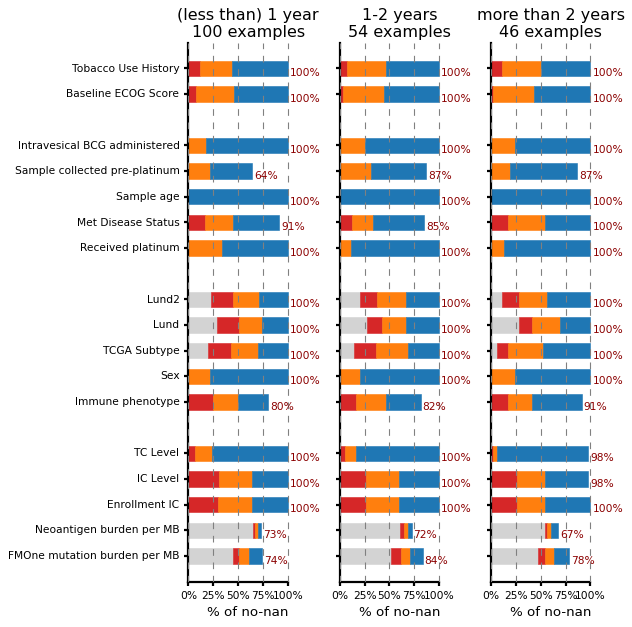

In [153]:
# Function, ............................................................................    
def simplified_df_summary_plot(*, 
    df,
    fname,
    top_n=3,
    fig_size=(8,6),
    groupSize=5,
    barPlot_dct=dict(),
    verbose=False                     
):
    # global settings - legacy code, 
    add_all_groups=True
    
    # find unique class labels in a feature
    'sorry for that expression, it was late and I had no internet, it shoudl be improved'
    unique_labels = df[fname].unique().tolist()
    unique_labels = pd.Series(unique_labels).loc[pd.Series(unique_labels).isnull()==False].tolist()

    # create the figure
    plt.style.use("classic")
    fig, axs = plt.subplots(nrows=1, ncols=len(unique_labels), figsize=fig_size, facecolor="white")

    # get 
    for i, class_name in enumerate(unique_labels):
        # get the data
        df_sub = df.loc[df[fname]==class_name,:]
        
        # get one axis
        if len(unique_labels)==1:
            ax = axs
        else:
            ax = axs[i]
            
        # remove barlbales from further axes
        if i==0:
            short_bar_names=None
        else:
            short_bar_names=""    
        
        # prepare data directly from dataframe
        data_examples, _, top_values_perc = summarize_df(  
                df = df_sub, 
                nr_of_examples_per_category = top_n,
                csv_file_name = None, 
                save_dir = None,
                verbose=verbose
            )

        # Pie chart with nr of col with different dtypes in data df,
        df_filter = pd.Series([True]*data_examples.shape[0])

        # add annotated barplot to axis
        ax = simplified_annotated_barplot(
                        ax = ax,
                        data_examples = data_examples, 
                        top_val_perc = top_values_perc, 
                        df_filter = df_filter, 
                        fig_size = fig_size,
                        group_size = groupSize,
                        short_bar_names=short_bar_names,
                        **barPlot_dct
                    )
        
        ax.set_title(f'{class_name}\n{df_sub.shape[0]} examples')
        
    fig.tight_layout()
    plt.show()

    

    
# check for missing data , and examples in each variable
simplified_df_summary_plot(
    df=data_cov,
    fname="Sample age",
    fig_size=(8,8),
    barPlot_dct=configs_barPlot) 



In [124]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get basic plt   functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 

import matplotlib.gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from IPython.display import display
from PIL import Image, ImageDraw
from matplotlib import colors
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_datetime64_any_dtype
from matplotlib.font_manager import FontProperties




# Function, ............................................................................    
def simplified_df_summary_plot(*, 
    df,
    fname,
    top_n=3,
    fig_size=(8,6),
    groupSize=5,
    barPlot_dct=dict(),
    verbose=False                     
):
    # global settings - legacy code, 
    add_all_groups=True
    
    # find unique class labels in a feature
    'sorry for that expression, it was late and I had no internet, it shoudl be improved'
    unique_labels = df[fname].unique().tolist()
    unique_labels = pd.Series(unique_labels).loc[pd.Series(unique_labels).isnull()==False].tolist()

    # create the figure
    plt.style.use("classic")
    fig, axs = plt.subplots(nrows=1, ncols=len(unique_labels), figsize=fig_size, facecolor="white")

    # get 
    for i, class_name in enumerate(unique_labels):
        # get the data
        df_sub = df.loc[df[fname]==class_name,:]
        
        # get one axis
        if len(unique_labels)==1:
            ax = axs
        else:
            ax = axs[i]
            
        # remove barlbales from further axes
        if i==0:
            short_bar_names=None
        else:
            short_bar_names=""    
        
        # prepare data directly from dataframe
        data_examples, _, top_values_perc = summarize_df(  
                df = df_sub, 
                nr_of_examples_per_category = top_n,
                csv_file_name = None, 
                save_dir = None,
                verbose=verbose
            )

        # Pie chart with nr of col with different dtypes in data df,
        df_filter = pd.Series([True]*data_examples.shape[0])

        # add annotated barplot to axis
        ax = simplified_annotated_barplot(
                        ax = ax,
                        data_examples = data_examples, 
                        top_val_perc = top_values_perc, 
                        df_filter = df_filter, 
                        fig_size = fig_size,
                        group_size = groupSize,
                        short_bar_names=short_bar_names,
                        **barPlot_dct
                    )
        
        ax.set_title(f'{class_name}\n{df_sub.shape[0]} examples')
        
    fig.tight_layout()
    plt.show()

    







# Function, ......................... 
def simplified_annotated_barplot(*, 
    # input data
    ax, 
    data_examples, 
    top_val_perc,                                                                        
    df_filter, 
    
    # plot aestetics
    plot_title="", 
    fig_size=(12,12), 
    fontsize_scale=1,
    examples_fontsize_scale=1,
    group_size=5,
    barplot_cmap="tab10",
    cmap_from=0, 
    cmap_to=0.5,
    adjust_top=0.8,
    short_bar_names=None
):
    
    
    '''
        Generates bar plot used to get fast information on data 
        in different column in large df
        
        Parameters/Input              
        _________________   _______________________________________________________________________________ 
        
        . Input .
        * data_examples     DataFrame with large Dataframe summary, 
                            generated with  summarize_data_and_give_examples()
        * top_val_perc      DataFrame with % of the top three or most frequence records in each column 
                            in large dataframe that was summarized with summarize_data_and_give_examples()
        
        .
        * df_filter         list, with True/False for each row in data_examples & top_val_perc 
                            if True, the row will be displayed on barplot
                            
        * fig_size          tuple, (row lenght, col lenght), in inches
        * font_size         int, size of all fonts used on the plot
        * group_size        int, how many rows will be diplayes as group on y axis on horizonal barplot.
                            groups are divided by space == to one bar.
                            
        Returns             matplotlib axis object
        _________________   _______________________________________________________________________________
        
        * plt.figure 
    '''
    
    # basic fontsize:
    font_size=8
    
    # helper,
    def stacked_barh_one_level(*, f_ax, bar_pos, top, bottom, colors, edgecolor, labels):
        f_ax.barh(bar_pos, top,left=bottom, color=colors, edgecolor=edgecolor, label=labels, linewidth=0.5, height=0.6)
        return f_ax    
    
    
    # ............................................................
    # Names and group filtering

    # group names,
    group_names       = list(data_examples.name.loc[df_filter])

    # data for plot,
    data_completness  = 100-np.array(data_examples.NaN_perc[df_filter]).flatten()
    tick_description  = data_examples.name[df_filter]
    top_values        = top_val_perc.values[df_filter, :]
    top_data_examples = data_examples.examples[df_filter]
    group_description = data_examples.summary[df_filter]

    # rescale top values,so they are part of non-missing data
    for i in range(top_values.shape[1]):
        v = top_values[:,i]
        top_values[:,i] = (v*data_completness)/100
    all_remaining_values = data_completness-top_values.sum(axis=1)

    # join the data in one array, I had some problems here, 
    data_for_plot = np.round(np.c_[(np.round(top_values,1), all_remaining_values)],1)

    

    # ............................................................
    # order the bars,

    # find order of the bars, based on data completness,
    bar_order = np.arange(data_completness.shape[0])

    # add spaces between everyx n-th bar, 
    add_spacers = True
    if add_spacers==True:
        # add spaces between everyx 5th bar, 
        space_between_groups = 1
        new_br = bar_order.copy().flatten()
        group_top  = []
        group_bottom = []

        for i, j in enumerate(sorted(list(bar_order))):

            if i==0: 
                add_to_list, counter = 0, 0
                group_bottom.append(j)

            if i>0 and counter<group_size: 
                counter +=1       

            if counter==group_size:
                group_bottom.append(j+add_to_list+1)
                counter=0
                add_to_list +=space_between_groups; 

            new_br[bar_order==j]=j+add_to_list

        group_top = [x+group_size-1 for x in group_bottom]    
        group_top[-1] = np.max(bar_order)+add_to_list
        bar_order = new_br.copy()
 
    # ............................................................
    # barplot parameters; this was just to help me in long function !
    numeric_data_for_plot = data_for_plot # np array, 
    top_data_examples     = top_data_examples
    bar_position          = bar_order + 1
    group_description     = group_description
    bar_related_fontsize  = font_size
    
    # bar_names, (ytick labels),
    if pd.isnull(short_bar_names):
        bar_names = group_names
    else:
        bar_names = [short_bar_names]*len(group_names)
        
    # ............................................................   
    # barplot,

    # Set style and colors,
    bar_colors = plt.get_cmap(barplot_cmap)(np.linspace(cmap_from, cmap_to, data_for_plot.shape[1])) # different nr of colors,
    edge_colors = bar_colors.copy()
    bar_colors[-1,0:3] = colors.to_rgb("lightgrey")
    edge_colors[-1,0:3] = colors.to_rgb("grey")

    # set axis limits
    plot_top_value = np.max(bar_position)+1
    ax.set_ylim(0,plot_top_value)
    ax.set_xlim(0,120)

    # add top values as % od data completness,
    counter =[]
    add_top_values=True
    if add_top_values==True:
        counter = 0
        for i in list(range(data_for_plot.shape[1]))[::-1]:
            if counter == 0:
                bar_start = [0]*data_for_plot.shape[0]    
                bar_end   = data_for_plot[:,i]
            else:
                bar_start = bar_start+bar_end           
                bar_end   = data_for_plot[:,i] # bar end is hot tall is an individual bar, segment, not top point on a graph
            counter+=1

            # plot level on stacked plot
            ax = stacked_barh_one_level(
                 f_ax=ax, 
                 bar_pos=bar_position, top=bar_end, bottom=bar_start, 
                 colors=bar_colors[i], edgecolor=bar_colors[i], labels="test",
                 )

    # Add ticks on y axis, and names for each bar,
    ax.set_yticks(bar_position)
    ax.set_yticklabels(bar_names, fontsize=bar_related_fontsize*fontsize_scale, color="black")
    ax.set_xticks([0, 25,50,75,100])
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"], fontsize=bar_related_fontsize*fontsize_scale, color="black")

    # Format ticks,
    ax.tick_params(axis='x', colors='black', direction='out', length=4, width=2) # tick only
    ax.tick_params(axis='y', colors='black', direction='out', length=4, width=2) # tick only    
    ax.yaxis.set_ticks_position('left')# shows only that
    ax.xaxis.set_ticks_position('bottom')# shows only that

    # Remove ticks, and axes that you dot'n want, format the other ones,
    ax.spines['top'].set_visible(False) # remove ...
    ax.spines['right'].set_visible(False) # remove ...  
    ax.spines['bottom'].set_linewidth(2) # x axis width
    ax.spines['bottom'].set_bounds(0,100) # Now the x axis do not go under the legend
    ax.spines['left'].set_linewidth(2) # y axis width 

    # Add vertical lines from grid,
    ax.xaxis.grid(color='grey', linestyle='--', linewidth=1) # horizontal lines

    # axes desciption
    ax.set_xlabel(f"% of no-nan")

    # add text with data completness above each bar,
    add_text_wiht_data_completness_above_each_bar=True
    if add_text_wiht_data_completness_above_each_bar==True:
        for i in range(numeric_data_for_plot.shape[0]):
            text_y_position = bar_position[i]-0.3
            text_x_position = numeric_data_for_plot.sum(axis=1).tolist()[i]+2

            # text,
            text_to_display = "".join([str(int(np.round(numeric_data_for_plot.sum(axis=1).tolist()[i],0))),"%"])
            t = ax.text(text_x_position, text_y_position,  text_to_display, fontsize=bar_related_fontsize*fontsize_scale, color="darkred")
            #t.set_bbox(dict(facecolor="white", alpha=0.3, edgecolor="white"))
    else: 
        pass

    return ax


   
# Function, .............................             
def summarize_df(*, df, nr_of_examples_per_category=3, csv_file_name=None, save_dir=None, verbose=False):
    """
        Summary table, with basic information on column in large dataframes,
        can be applied to dafarames of all sizes, Used to create summary plots
        
        IMPORTANT: this is one of my oldest function, that I am using a lot, 
                   I will soon update it to something better, but generating the same outputs, 
                   and more resiliant to unknownw datatypes, 
        
        Parameters/Input              
        _________________   _______________________________________________________________________________ 
        
        . Input .
        * df                DataFrame to summarize
        * nr_of_examples_per_category
                            how many, top/most frequent records shoudl 
                            be collected in each column and used as examples of data inputs form that column
                            NaN, are ignored, unless column has only NaN
        
        . Saving .          The fgunction return Dataframe, even if file name and path to save_dir are not available
                            In that case the file are not saved.
        * csv_file_name     .csv file name that will be used to save all three dataFrames create with that function
        * save_dir          path
        
        Returns             
        _________________   _______________________________________________________________________________
        
        * data_examples.    DataFrame, summary of df, with the follwing values for each column imn df
                            . name                       : column name in df, attribute name
                            . dtype.                 : {"nan", if ony NaN werer detected in df, "object", "numeric"}
                            . NaN_perc               : percentage of missing data (np.nan, pd.null) in df in a given attirbute
                            . summary                : shor informtaion on type and number of data we shoudl expectc:
                                                       if dtype == "numeric": return min, mean and max values
                                                       if dtype == "object" : return number of unique classes
                                                              or messsage "all nonnull values are unique"
                                                       if dtype == nan       : return "Missing data Only"                        
                            . examples                : str, with reqwuested number of most frequent value examples in a given category
                            . nr_of_unique_values         : numeric, scount of all unique values in a category 
                            . nr_of_non_null_values   : numeric, count of all non-null values in a category
        
        * top_val_perc      DataFrame with % of the top three or most frequence records in each column 
                            in large dataframe that was summarized with summarize_data_and_give_examples()

        * top_val_names     DataFrame, same as top_val_perc, but with values, saved as string
 
    """    
    
    
    assert type(df)==pd.DataFrame, "ERROR, df must be pandas dataframe"
    
    # info
    if csv_file_name!="none" and save_dir!="none":
        if verbose == True:
            print("\n! CAUTION ! csv_file_name shoudl be provided wihtout .csv file extension!")
        else:
            pass

    # create df,
    col_names   =["All_values_are_unique", "Nr_of_unique_values", "Nr_of_non_null_values", 
                  "Examples","dtype", "nr_of_all_rows_in_original_df"]
    df_examples = pd.DataFrame(np.zeros([df.shape[1],len(col_names)]), columns=col_names, dtype="object")

    # add category names
    df_examples["name"] = df.columns

    # add NaN percentage,
    nan_counts_per_category = df.isnull().sum(axis=0)
    my_data = pd.DataFrame(np.round((nan_counts_per_category/df.shape[0])*100, 5), dtype="float64")
    df_examples["NaN_perc"] = my_data.reset_index(drop=True)

    # add nr of no NaN values
    my_data = df.shape[0]-nan_counts_per_category
    df_examples["Nr_of_non_null_values"] = my_data.reset_index(drop=True)

    # add "nr_of_all_rows_in_original_df"
    df_examples["nr_of_all_rows_in_original_df"] = df.shape[0]
    
    # these arr will be filled for future bar plot
    arr_example_percentage = np.zeros([df_examples.shape[0],nr_of_examples_per_category])
    arr_example_values     = np.zeros([df_examples.shape[0],nr_of_examples_per_category],dtype="object")
    
    
    
    # add examples and counts
    for i, j in enumerate(list(df.columns)):

        # add general data  ..............................................

        # number of unique nonnull values in each column,
        df_examples.loc[df_examples.name==j,"Nr_of_unique_values"] = df.loc[:,j].dropna().unique().size

        
        #  internal function helpers .....................................

        # categorical data, fillin_All_values_are_unique
        def fillin_All_values_are_unique(*, df_examples, df):
            if (df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"]==0).values[0]: 
                return "Missing data Only"
            elif ((df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"]>0).values[0]) and (df.loc[:,j].dropna().unique().size==df.loc[:,j].dropna().shape[0]): 
                return "all nonnull values are unique"
            elif ((df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"]>0).values[0]) and (df.loc[:,j].dropna().unique().size!=df.loc[:,j].dropna().shape[0]): 
                return f"{int(df_examples.Nr_of_unique_values[df_examples.name==j].values[0])} classes"
            else:
                pass
            
            
            
        # fill other columns ..............................................

        # this is auto-fill in case there is no data
        if df[j].isnull().sum()==df.shape[0]:
            # (df_examples.loc[df_examples.name==j,"NaN_perc"]==100).values[0]: this value was rounded up/down and was returning false positives!!!!
            df_examples.loc[df_examples.name==j,"All_values_are_unique"] = "missing data only"
            df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"] = 0 # it should be 0, but i overwrite it just in case
            df_examples.loc[df_examples.name==j,"Nr_of_unique_values"] = 0 # it should be 0, but i overwrite it just in case
            df_examples.loc[df_examples.name==j,"Examples"] = "missing data only"
            df_examples.loc[df_examples.name==j,"dtype"] = "missing data only" # because I dont want to use that in any further reading

        # in other cases, we can create data examples, from nonnull values, depending on their type,
        else:

            if is_string_dtype(df[j]): 

                # dtype,
                df_examples.loc[df_examples.name==j,"dtype"]= "text"
                
                # All_values_are_unique,
                # use helper function, to find if there are only unique categorical values eg: url, place example in dct,  
                df_examples.loc[df_examples.name==j,"All_values_are_unique"] = fillin_All_values_are_unique(df_examples=df_examples, df=df)

                # Examples,
                count_noNa_values_sorted = df.loc[:,j].dropna().value_counts().sort_values(ascending=False)
                perc_noNa_values_sorted  = count_noNa_values_sorted/np.sum(count_noNa_values_sorted)*100
                s        = perc_noNa_values_sorted.iloc[0:nr_of_examples_per_category].round(1)
                if len(s.index.values.tolist())>0:
                    ind      = pd.Series(s.index).values.tolist()
                else:
                    ind = [""]*nr_of_examples_per_category
                df_examples.loc[df_examples.name==j,"Examples"] = ";".join([str((x,y)) for x,y in zip(["".join([str(x),"%"]) for x in list(s)],ind)])

                            
                # add examples to arr for plot
                arr_example_percentage[df_examples.name==j,0:s.values.size]=s.values[0:nr_of_examples_per_category] 
                arr_example_values[df_examples.name==j,0:s.values.size]= np.array(s.index)[0:nr_of_examples_per_category]


            elif is_numeric_dtype(df[j]): 

                # dtype,
                df_examples.loc[df_examples.name==j,"dtype"]= "numeric"
                
                # All_values_are_unique,
                x = list(df.loc[:,j].dropna().describe()[["min", "mean", "max"]].round(3))
                df_examples.loc[df_examples.name==j,"All_values_are_unique"] = f"{round(x[0],2)} // {round(x[1],2)} // {round(x[2],2)}"

                # Examples,
                ordered_values = df.loc[:,j].dropna().value_counts().sort_values(ascending=False)
                ordered_values = (ordered_values/df.loc[:,j].dropna().shape[0])*100
                df_examples.loc[df_examples.name==j,"Examples"] = ";".join([str((x,y)) for x,y in zip(
                    ["".join([str(int(np.ceil(x))),"%"]) for x in list(ordered_values)][0:nr_of_examples_per_category],
                    list(ordered_values.index.values.round(3))[0:nr_of_examples_per_category])])

                # add examples to arr for plot
                vn = np.array(ordered_values.index)[0:nr_of_examples_per_category]
                vp = ordered_values.values[0:nr_of_examples_per_category]
                arr_example_values[df_examples.name==j,0:ordered_values.size] = vn
                arr_example_percentage[df_examples.name==j,0:ordered_values.size] = vp
                
            elif is_datetime64_any_dtype(df[j]): 

                # dtype,
                df_examples.loc[df_examples.name==j,"dtype"]= "datetime"
                
                # variable summary,
                first_and_last_date = [str(x) for x in list(df.loc[:,j].dropna().describe()[["first", "last"]].dt.strftime('%b %d %Y'))]
                df_examples.loc[df_examples.name==j,"All_values_are_unique"] = f"{first_and_last_date[0]} - {first_and_last_date[1]}"

                # Examples,
                ordered_values = df.loc[:,j].dropna().value_counts().sort_values(ascending=False)
                ordered_values = (ordered_values/df.loc[:,j].dropna().shape[0])*100
                df_examples.loc[df_examples.name==j,"Examples"] =";".join([str((x,y)) for x,y in zip(
                    ["".join([str(np.round(x,3)),"%"]) for x in list(ordered_values)][0:2], 
                    list(pd.Series(ordered_values.index[0:2]).dt.strftime('%b-%d-%Y %H:%M').values))])# i add only two, because these are really long, 

                # add examples to arr for plot
                vn = list(ordered_values.index)[0:nr_of_examples_per_category]
                vp = ordered_values.values[0:nr_of_examples_per_category]
                arr_example_values[df_examples.name==j,0:ordered_values.size] = vn
                arr_example_percentage[df_examples.name==j,0:ordered_values.size] = vp     
                
            else:
                pass

                # (df_examples.loc[df_examples.name==j,"NaN_perc"]==100).values[0]: this value was rounded up/down and was returning false positives!!!!
                df_examples.loc[df_examples.name==j,"All_values_are_unique"] = "Uknown datatype"
                df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"] = 0 # it should be 0, but i overwrite it just in case
                df_examples.loc[df_examples.name==j,"Nr_of_unique_values"] = 0 # it should be 0, but i overwrite it just in case
                df_examples.loc[df_examples.name==j,"Examples"] = "Uknown datatype"
                df_examples.loc[df_examples.name==j,"dtype"] = "Uknown datatype" # because I dont want to use that in any further reading


                
    # reorder column, so the look nicer, when displayed, 
    df_examples = df_examples.loc[:,["name", "dtype", 'NaN_perc', 'All_values_are_unique', 'Examples', 
                                     'Nr_of_unique_values', 'Nr_of_non_null_values', 'nr_of_all_rows_in_original_df']]   
    # rename some collumns, for PEP8 compliance,
    df_examples = df_examples.rename(columns={'All_values_are_unique':'summary', "Examples": "examples", 
                                              "Nr_of_unique_values": "nr_of_unique_values", "Nr_of_non_null_values":"nr_of_non_null_values"})
    

    # turn two additional elements into df's, 
    df_example_values = pd.DataFrame(arr_example_values, index=df_examples.name)
    df_example_percentage = pd.DataFrame(arr_example_percentage, index=df_examples.name)
    
    #### save the files 
    if csv_file_name!=None and save_dir!=None:
        try:
            os.chdir(save_dir)
            df_examples.to_csv("".join([csv_file_name,".csv"]), encoding='utf-8', index=False)
            df_example_values.to_csv("".join(["top_val_names_",csv_file_name,".csv"]), encoding='utf-8', index=False)
            df_example_percentage.to_csv("".join(["top_val_perc_",csv_file_name,".csv"]), encoding='utf-8', index=False)
            
            # info to display,and table example, 
            if verbose==True:
                print(f"""the file: {csv_file_name} was correctly saved \n in: {os.getcwd()} \n""") 
            else:
                pass

        except:
            if verbose==True:
                Error_message = "THE FILE WAS NOT SAVED, \n save_dir and/or csv_file_name were incorrect, or one of them was not provided"
                print(f"""{"".join(["."]*40)},\n ERROR,\n the file: {csv_file_name},\n {Error_message} \n in: {os.getcwd()} \n{"".join(["."]*40)}""")
            else:
                pass
                
    else:
        if verbose==True:
            Error_message = "THE FILE WAS NOT SAVED, \n save_dir and/or csv_file_name were not provided "
            print(f"""{"".join(["."]*40)},\n CAUTION,\n the file: {csv_file_name},\n {Error_message} \n in: {os.getcwd()} \n{"".join(["."]*40)}""")
        else:
            pass
    
    return df_examples, df_example_values, df_example_percentage

In [62]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get basic plt   functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 

import matplotlib.gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from IPython.display import display
from PIL import Image, ImageDraw
from matplotlib import colors
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_datetime64_any_dtype
from matplotlib.font_manager import FontProperties


# Function, ......................... 
def simplified_annotated_barplot(*, 
    # input data
    data_examples, 
    top_val_perc,                                                                        
    df_filter, 
    
    # plot aestetics
    plot_title="", 
    fig_size=(12,12), 
    fontsize_scale=1,
    examples_fontsize_scale=1,
    group_size=5,
    barplot_cmap="tab10",
    cmap_from=0, 
    cmap_to=0.5,
    adjust_top=0.8
):
    
    
    '''
        Generates bar plot used to get fast information on data 
        in different column in large df
        
        Parameters/Input              
        _________________   _______________________________________________________________________________ 
        
        . Input .
        * data_examples     DataFrame with large Dataframe summary, 
                            generated with  summarize_data_and_give_examples()
        * top_val_perc      DataFrame with % of the top three or most frequence records in each column 
                            in large dataframe that was summarized with summarize_data_and_give_examples()
        
        .
        * df_filter         list, with True/False for each row in data_examples & top_val_perc 
                            if True, the row will be displayed on barplot
                            
        * fig_size          tuple, (row lenght, col lenght), in inches
        * font_size         int, size of all fonts used on the plot
        * group_size        int, how many rows will be diplayes as group on y axis on horizonal barplot.
                            groups are divided by space == to one bar.
                            
        Returns             
        _________________   _______________________________________________________________________________
        
        * plt.figure 
    '''
    
    # basic fontsize:
    font_size=8
    
    # helper,
    def stacked_barh_one_level(*, f_ax, bar_pos, top, bottom, colors, edgecolor, labels):
        f_ax.barh(bar_pos, top,left=bottom, color=colors, edgecolor=edgecolor, label=labels, linewidth=0.5, height=0.6)
        return f_ax    
    
    
    # ............................................................
    # Names and group filtering

    # group names,
    group_names       = list(data_examples.name.loc[df_filter])

    # data for plot,
    data_completness  = 100-np.array(data_examples.NaN_perc[df_filter]).flatten()
    tick_description  = data_examples.name[df_filter]
    top_values        = top_val_perc.values[df_filter, :]
    top_data_examples = data_examples.examples[df_filter]
    group_description = data_examples.summary[df_filter]

    # rescale top values,so they are part of non-missing data
    for i in range(top_values.shape[1]):
        v = top_values[:,i]
        top_values[:,i] = (v*data_completness)/100
    all_remaining_values = data_completness-top_values.sum(axis=1)

    # join the data in one array, I had some problems here, 
    data_for_plot = np.round(np.c_[(np.round(top_values,1), all_remaining_values)],1)

    

    # ............................................................
    # order the bars,

    # find order of the bars, based on data completness,
    bar_order = np.arange(data_completness.shape[0])

    # add spaces between everyx n-th bar, 
    add_spacers = True
    if add_spacers==True:
        # add spaces between everyx 5th bar, 
        space_between_groups = 1
        new_br = bar_order.copy().flatten()
        group_top  = []
        group_bottom = []

        for i, j in enumerate(sorted(list(bar_order))):

            if i==0: 
                add_to_list, counter = 0, 0
                group_bottom.append(j)

            if i>0 and counter<group_size: 
                counter +=1       

            if counter==group_size:
                group_bottom.append(j+add_to_list+1)
                counter=0
                add_to_list +=space_between_groups; 

            new_br[bar_order==j]=j+add_to_list

        group_top = [x+group_size-1 for x in group_bottom]    
        group_top[-1] = np.max(bar_order)+add_to_list
        bar_order = new_br.copy()

        
        
    # ............................................................
    # barplot parameters; this was just to help me in long function !
    numeric_data_for_plot = data_for_plot # np array, 
    top_data_examples     = top_data_examples
    bar_position          = bar_order + 1
    group_description     = group_description
    bar_related_fontsize  = font_size
    
    # bar_names, (ytick labels),
    # if len(list(data_examples.dtype[df_filter].unique()))>1:
    df_bar_names       = pd.DataFrame({"col_1":group_names, "col_2":list(data_examples.dtype[df_filter])}) 
    df_bar_names.col_2 = df_bar_names.col_2.str.pad(width=20, side="left", fillchar=".")
    bar_names          = list(df_bar_names.col_1.str.cat([", "]*df_bar_names.shape[0]).str.cat(df_bar_names.col_2))
    #else:
    #    bar_names          = group_names # list, old script, now chnaged as in below
        
  

    # ............................................................   
    # barplot,

    #### prepare data and figure, 
    
    # Set style and colors,
    plt.style.use("classic")
    bar_colors = plt.get_cmap(barplot_cmap)(np.linspace(cmap_from, cmap_to, data_for_plot.shape[1])) # different nr of colors,
    edge_colors = bar_colors.copy()
    bar_colors[-1,0:3] = colors.to_rgb("lightgrey")
    edge_colors[-1,0:3] = colors.to_rgb("grey")

    # fig
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fig_size, facecolor="white")
    fig.suptitle(plot_title)
    plot_top_value = np.max(bar_position)+15
    ax.set_ylim(0,plot_top_value)
    ax.set_xlim(0,300)

    # add top values as % od data completness,
    counter =[]
    add_top_values=True
    if add_top_values==True:
        counter = 0
        for i in list(range(data_for_plot.shape[1]))[::-1]:
            if counter == 0:
                bar_start = [0]*data_for_plot.shape[0]    
                bar_end   = data_for_plot[:,i]
            else:
                bar_start = bar_start+bar_end           
                bar_end   = data_for_plot[:,i] # bar end is hot tall is an individual bar, segment, not top point on a graph
            counter+=1

            # plot level on stacked plot
            ax = stacked_barh_one_level(
                 f_ax=ax, 
                 bar_pos=bar_position, top=bar_end, bottom=bar_start, 
                 colors=bar_colors[i], edgecolor=bar_colors[i], labels="test",
                 )


            
    #### ad legend on y axis        

    # Add ticks on y axis, and names for each bar,
    ax.set_yticks(bar_position)
    ax.set_yticklabels(bar_names, fontsize=bar_related_fontsize*fontsize_scale, color="black")
    ax.set_xticks([0, 25,50,75,100])
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"], fontsize=bar_related_fontsize*fontsize_scale, color="black")

    # Format ticks,
    ax.tick_params(axis='x', colors='black', direction='out', length=4, width=2) # tick only
    ax.tick_params(axis='y', colors='black', direction='out', length=4, width=2) # tick only    
    ax.yaxis.set_ticks_position('left')# shows only that
    ax.xaxis.set_ticks_position('bottom')# shows only that

    # Remove ticks, and axes that you dot'n want, format the other ones,
    ax.spines['top'].set_visible(False) # remove ...
    ax.spines['right'].set_visible(False) # remove ...  
    ax.spines['bottom'].set_linewidth(2) # x axis width
    ax.spines['bottom'].set_bounds(0,100) # Now the x axis do not go under the legend
    ax.spines['left'].set_linewidth(2) # y axis width 

    # Add vertical lines from grid,
    ax.xaxis.grid(color='grey', linestyle='--', linewidth=1) # horizontal lines

    # add patch on top to remove surplus gridlines
    x_left      = -100
    rect_width  = 500
    y_bottom    = np.max(bar_position)+1.4 # add a bit to nut cut text opr boxes,
    rect_height = 500
    rect = mpatches.Rectangle(
        xy=(x_left,y_bottom),
        width=rect_width,
        height=rect_height,
        linewidth=0,
        edgecolor='white',
        facecolor='white',
        alpha=1, 
        zorder=10
    )
    ax.add_patch(rect)
    plt.ylim(top=np.max(bar_position)+1.4)

    # axes desciption    
    ax.set_xlabel(f"Percentage of non-missing data, rows in total={data_examples.nr_of_all_rows_in_original_df.iloc[0]}                           ", ha="right") # I intentionally, added these spaces here!
    ax.set_ylabel("Column name, datatype", ha="center")


    
    #### add, numbers and examples on a left side of the barplot, 

    # add rectagles arrnoud examples
    for i, j in zip(group_bottom, group_top):
        x_left      = 113
        rect_width  = 186
        y_bottom    = i+0.2
        rect_height = j-i+1.5
        rect = mpatches.Rectangle(
            xy=(x_left,y_bottom),
            width=rect_width,
            height=rect_height,
            linewidth=1,
            edgecolor="darkgreen",
            facecolor='yellow',
            alpha=0.3
        )
        ax.add_patch(rect)

    # add text with data completness above each bar,
    add_text_wiht_data_completness_above_each_bar=True
    if add_text_wiht_data_completness_above_each_bar==True:
        for i in range(numeric_data_for_plot.shape[0]):
            text_y_position = bar_position[i]-0.3
            text_x_position = numeric_data_for_plot.sum(axis=1).tolist()[i]+2

            # text,
            text_to_display = "".join([str(int(np.round(numeric_data_for_plot.sum(axis=1).tolist()[i],0))),"%"])
            t = ax.text(text_x_position, text_y_position,  text_to_display, fontsize=bar_related_fontsize*fontsize_scale, color="darkred")
            #t.set_bbox(dict(facecolor="white", alpha=0.3, edgecolor="white"))
    else: 
        pass

    # Add table, with data to plot,
    for i in range(numeric_data_for_plot.shape[0]):
        text_y_position = bar_position[i]-0.3
        text_x_position = 115

        # text,
        text_to_display = list(group_description)[i]
        t = ax.text(text_x_position, text_y_position,  text_to_display, fontsize=bar_related_fontsize*fontsize_scale, color="black")

    # add examples,   
    for i in range(numeric_data_for_plot.shape[0]):
        text_y_position = bar_position[i]-0.3
        text_x_position = 170

        # text,
        if re.search("all nonnull",str(list(group_description)[i])):
            text_to_display = "".join(["- - - > ",list(top_data_examples)[i]])
        else: text_to_display = list(top_data_examples)[i]
        t = ax.text(text_x_position, text_y_position,  text_to_display, fontsize=(bar_related_fontsize)*fontsize_scale*examples_fontsize_scale, color="black")

        
        
    #### add plot legend  
    box_color       = "yellowgreen"
    box_edge_color  = "darkgreen"
    text_color      = "black" 
    text_size       = bar_related_fontsize

    text_x_position = 3
    text_y_position = np.max(bar_position)+2.5
    text_to_display = '''BAR DESCRIPTION\n- each bar shows % of non-missing data in a given columns\n- Colour bars on top, shows the % of the most frequent classes'''   
    t = ax.text(text_x_position, text_y_position,  text_to_display, fontsize=text_size*fontsize_scale, color=text_color, ha="left")
    t.set_bbox(dict(facecolor=box_color, alpha=1, edgecolor=box_edge_color))

    text_x_position = 115
    text_y_position = np.max(bar_position)+2.5
    text_to_display = '''FEATURE SUMMARY \n - numeric.: min; mean; max \n - string/time: nr of classes'''
    t = ax.text(text_x_position, text_y_position,  text_to_display, fontsize=text_size*fontsize_scale, color=text_color, ha="left")
    t.set_bbox(dict(facecolor=box_color, alpha=1, edgecolor=box_edge_color))

    text_x_position = 175
    text_y_position = np.max(bar_position)+2.5
    text_to_display = '''EXAMPLES of the most Frequent Non-Missing Values:\n - first: %of rows, with a given class, \n - second: class value, or the first 15-th characters'''
    t = ax.text(text_x_position, text_y_position,  text_to_display, fontsize=text_size*fontsize_scale, color=text_color, ha="left")
    t.set_bbox(dict(facecolor=box_color, alpha=1, edgecolor=box_edge_color))
    
    fig.subplots_adjust(top=adjust_top)
    plt.show();
    


 
    
# Function, ............................................................................    
def df_summary_plot(*, 
    # input data (either df or data_examples & top_values_perc)
    df=None,
    df_top_n=3,
    data_examples=None, 
    top_values_perc=None, 
    
    # options on dat to display, 
    groups_to_display=None, 
    barPlot=True, # legacy term, 
                          
    # settings, 
    barPlot_figsize=None,
    barPlot_groupSize=None,
    barPlot_dct=dict(),
    verbose=False      
               
):
 
    """
        Plots Pie chart, table and barplot summarizing data in large dataFrame
        
        Parameters/Input              
        _________________   _______________________________________________________________________________  
        
        . Input .
        
        * data_examples     DataFrame with large Dataframe summary, 
                            generated with  summarize_data_and_give_examples()
        * top_val_perc      DataFrame with % of the top three or most frequence records in each column 
                            in large dataframe that was summarized with summarize_data_and_give_examples()
        * groups_to_display str, or list with strings, {"all", "text", "numeric", "datetime"}
                            "all", (default), or one of the dtypes, in data_examples.dtype, 
                            or list with different dtypes that will be ploted on rseraprate barplots
                            Columns only with missing data are not included in groups, these are plotted
                            only with "all" default option
                
        . Parameters . 
        
        * start_figure_numbers_at 
                            >=1, how nto start numeration of the figures with plots
        * pieChart          if True (default), display Pie chart with dtypes detected in data_examples
                            with number start_figure_numbers_at 
        * showTable         if True (default), display image of a summary table
                            with number start_figure_numbers_at + 1
        * barPlot.          if True (default), displays
                            with number start_figure_numbers_at  + 2, 3,4 and so on for each dtype
                            
                            
        Returns               
        _________________   _______________________________________________________________________________
        
         * BarPlot           by :   barplot_with_data_completness_class_description_and_top_value_examples()
        
    """    

    # set up groups to be selected 
    if groups_to_display==None:
        groups_to_display="all"
    elif isinstance(groups_to_display, str):
        if groups_to_display=="all":
            pass
        else:
            groups_to_display=[groups_to_display]
    else:
        pass
    
    # prepare data directly from datafram, or use summary df elements caluated separately, 
    if data_examples is None or top_values_perc is None: 
        data_examples, _, top_values_perc = summarize_df(  
            df = df, 
            nr_of_examples_per_category = df_top_n,
            csv_file_name = None, 
            save_dir = None,
            verbose=verbose
        )
    else:
        pass

 
    # Pie chart with nr of col with different dtypes in data df,
    if barPlot==True:
        
        # .. barplot for each column with any non-missing data, eacg dtype is plotted separately,
        if groups_to_display=="all": 
            groups_to_display=["all"]; add_all_groups=True
        else: 
            add_all_groups=False
        
        
        for i, group_name in enumerate(groups_to_display): 
            
            # filter the data, and plot title, 
            if add_all_groups:
                df_filter         = pd.Series([True]*data_examples.shape[0])
            else:
                df_filter         = data_examples['dtype']==group_name

                
            # test, if the given group was present:  
            if df_filter.sum()==0:
                if verbose==True:
                    print("- - -THERE WERE NO COLUMNS WITH THAT DATA TYPE IN SEARCHED DataFrame - - -", end="\n\n")
                else:
                    pass
            else:
                # set size for the figure with barplot, 
                if df_filter.sum()>0 and df_filter.sum()<=10:
                    figSize = (12,5)
                    groupSize = df_filter.sum()

                elif df_filter.sum()>10:
                    figSize = (16,16)
                    groupSize = 5  
                 
                elif df_filter.sum()>50:
                    figSize = (12,22)
                    groupSize = 8  
                    
                # replace values in case 
                if barPlot_figsize!=None:
                    figSize= barPlot_figsize
                else:
                    pass
                if barPlot_groupSize!=None:
                    groupSize = barPlot_groupSize
                else:
                    pass
                
                    
                ##    
                annotated_barplot(
                    data_examples = data_examples, 
                    top_val_perc  = top_values_perc, 
                    df_filter     = df_filter, 
                    fig_size      = figSize,
                    group_size    = groupSize,
                    **barPlot_dct
                )


# Function, .............................             
def summarize_df(*, df, nr_of_examples_per_category=3, csv_file_name=None, save_dir=None, verbose=False):
    """
        Summary table, with basic information on column in large dataframes,
        can be applied to dafarames of all sizes, Used to create summary plots
        
        IMPORTANT: this is one of my oldest function, that I am using a lot, 
                   I will soon update it to something better, but generating the same outputs, 
                   and more resiliant to unknownw datatypes, 
        
        Parameters/Input              
        _________________   _______________________________________________________________________________ 
        
        . Input .
        * df                DataFrame to summarize
        * nr_of_examples_per_category
                            how many, top/most frequent records shoudl 
                            be collected in each column and used as examples of data inputs form that column
                            NaN, are ignored, unless column has only NaN
        
        . Saving .          The fgunction return Dataframe, even if file name and path to save_dir are not available
                            In that case the file are not saved.
        * csv_file_name     .csv file name that will be used to save all three dataFrames create with that function
        * save_dir          path
        
        Returns             
        _________________   _______________________________________________________________________________
        
        * data_examples.    DataFrame, summary of df, with the follwing values for each column imn df
                            . name                       : column name in df, attribute name
                            . dtype.                 : {"nan", if ony NaN werer detected in df, "object", "numeric"}
                            . NaN_perc               : percentage of missing data (np.nan, pd.null) in df in a given attirbute
                            . summary                : shor informtaion on type and number of data we shoudl expectc:
                                                       if dtype == "numeric": return min, mean and max values
                                                       if dtype == "object" : return number of unique classes
                                                              or messsage "all nonnull values are unique"
                                                       if dtype == nan       : return "Missing data Only"                        
                            . examples                : str, with reqwuested number of most frequent value examples in a given category
                            . nr_of_unique_values         : numeric, scount of all unique values in a category 
                            . nr_of_non_null_values   : numeric, count of all non-null values in a category
        
        * top_val_perc      DataFrame with % of the top three or most frequence records in each column 
                            in large dataframe that was summarized with summarize_data_and_give_examples()

        * top_val_names     DataFrame, same as top_val_perc, but with values, saved as string
 
    """    
    
    
    assert type(df)==pd.DataFrame, "ERROR, df must be pandas dataframe"
    
    # info
    if csv_file_name!="none" and save_dir!="none":
        if verbose == True:
            print("\n! CAUTION ! csv_file_name shoudl be provided wihtout .csv file extension!")
        else:
            pass

    # create df,
    col_names   =["All_values_are_unique", "Nr_of_unique_values", "Nr_of_non_null_values", 
                  "Examples","dtype", "nr_of_all_rows_in_original_df"]
    df_examples = pd.DataFrame(np.zeros([df.shape[1],len(col_names)]), columns=col_names, dtype="object")

    # add category names
    df_examples["name"] = df.columns

    # add NaN percentage,
    nan_counts_per_category = df.isnull().sum(axis=0)
    my_data = pd.DataFrame(np.round((nan_counts_per_category/df.shape[0])*100, 5), dtype="float64")
    df_examples["NaN_perc"] = my_data.reset_index(drop=True)

    # add nr of no NaN values
    my_data = df.shape[0]-nan_counts_per_category
    df_examples["Nr_of_non_null_values"] = my_data.reset_index(drop=True)

    # add "nr_of_all_rows_in_original_df"
    df_examples["nr_of_all_rows_in_original_df"] = df.shape[0]
    
    # these arr will be filled for future bar plot
    arr_example_percentage = np.zeros([df_examples.shape[0],nr_of_examples_per_category])
    arr_example_values     = np.zeros([df_examples.shape[0],nr_of_examples_per_category],dtype="object")
    
    
    
    # add examples and counts
    for i, j in enumerate(list(df.columns)):

        # add general data  ..............................................

        # number of unique nonnull values in each column,
        df_examples.loc[df_examples.name==j,"Nr_of_unique_values"] = df.loc[:,j].dropna().unique().size

        
        #  internal function helpers .....................................

        # categorical data, fillin_All_values_are_unique
        def fillin_All_values_are_unique(*, df_examples, df):
            if (df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"]==0).values[0]: 
                return "Missing data Only"
            elif ((df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"]>0).values[0]) and (df.loc[:,j].dropna().unique().size==df.loc[:,j].dropna().shape[0]): 
                return "all nonnull values are unique"
            elif ((df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"]>0).values[0]) and (df.loc[:,j].dropna().unique().size!=df.loc[:,j].dropna().shape[0]): 
                return f"{int(df_examples.Nr_of_unique_values[df_examples.name==j].values[0])} classes"
            else:
                pass
            
            
            
        # fill other columns ..............................................

        # this is auto-fill in case there is no data
        if df[j].isnull().sum()==df.shape[0]:
            # (df_examples.loc[df_examples.name==j,"NaN_perc"]==100).values[0]: this value was rounded up/down and was returning false positives!!!!
            df_examples.loc[df_examples.name==j,"All_values_are_unique"] = "missing data only"
            df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"] = 0 # it should be 0, but i overwrite it just in case
            df_examples.loc[df_examples.name==j,"Nr_of_unique_values"] = 0 # it should be 0, but i overwrite it just in case
            df_examples.loc[df_examples.name==j,"Examples"] = "missing data only"
            df_examples.loc[df_examples.name==j,"dtype"] = "missing data only" # because I dont want to use that in any further reading

        # in other cases, we can create data examples, from nonnull values, depending on their type,
        else:

            if is_string_dtype(df[j]): 

                # dtype,
                df_examples.loc[df_examples.name==j,"dtype"]= "text"
                
                # All_values_are_unique,
                # use helper function, to find if there are only unique categorical values eg: url, place example in dct,  
                df_examples.loc[df_examples.name==j,"All_values_are_unique"] = fillin_All_values_are_unique(df_examples=df_examples, df=df)

                # Examples,
                count_noNa_values_sorted = df.loc[:,j].dropna().value_counts().sort_values(ascending=False)
                perc_noNa_values_sorted  = count_noNa_values_sorted/np.sum(count_noNa_values_sorted)*100
                s        = perc_noNa_values_sorted.iloc[0:nr_of_examples_per_category].round(1)
                if len(s.index.values.tolist())>0:
                    ind      = pd.Series(s.index).values.tolist()
                else:
                    ind = [""]*nr_of_examples_per_category
                df_examples.loc[df_examples.name==j,"Examples"] = ";".join([str((x,y)) for x,y in zip(["".join([str(x),"%"]) for x in list(s)],ind)])

                            
                # add examples to arr for plot
                arr_example_percentage[df_examples.name==j,0:s.values.size]=s.values[0:nr_of_examples_per_category] 
                arr_example_values[df_examples.name==j,0:s.values.size]= np.array(s.index)[0:nr_of_examples_per_category]


            elif is_numeric_dtype(df[j]): 

                # dtype,
                df_examples.loc[df_examples.name==j,"dtype"]= "numeric"
                
                # All_values_are_unique,
                x = list(df.loc[:,j].dropna().describe()[["min", "mean", "max"]].round(3))
                df_examples.loc[df_examples.name==j,"All_values_are_unique"] = f"{round(x[0],2)} // {round(x[1],2)} // {round(x[2],2)}"

                # Examples,
                ordered_values = df.loc[:,j].dropna().value_counts().sort_values(ascending=False)
                ordered_values = (ordered_values/df.loc[:,j].dropna().shape[0])*100
                df_examples.loc[df_examples.name==j,"Examples"] = ";".join([str((x,y)) for x,y in zip(
                    ["".join([str(int(np.ceil(x))),"%"]) for x in list(ordered_values)][0:nr_of_examples_per_category],
                    list(ordered_values.index.values.round(3))[0:nr_of_examples_per_category])])

                # add examples to arr for plot
                vn = np.array(ordered_values.index)[0:nr_of_examples_per_category]
                vp = ordered_values.values[0:nr_of_examples_per_category]
                arr_example_values[df_examples.name==j,0:ordered_values.size] = vn
                arr_example_percentage[df_examples.name==j,0:ordered_values.size] = vp
                
            elif is_datetime64_any_dtype(df[j]): 

                # dtype,
                df_examples.loc[df_examples.name==j,"dtype"]= "datetime"
                
                # variable summary,
                first_and_last_date = [str(x) for x in list(df.loc[:,j].dropna().describe()[["first", "last"]].dt.strftime('%b %d %Y'))]
                df_examples.loc[df_examples.name==j,"All_values_are_unique"] = f"{first_and_last_date[0]} - {first_and_last_date[1]}"

                # Examples,
                ordered_values = df.loc[:,j].dropna().value_counts().sort_values(ascending=False)
                ordered_values = (ordered_values/df.loc[:,j].dropna().shape[0])*100
                df_examples.loc[df_examples.name==j,"Examples"] =";".join([str((x,y)) for x,y in zip(
                    ["".join([str(np.round(x,3)),"%"]) for x in list(ordered_values)][0:2], 
                    list(pd.Series(ordered_values.index[0:2]).dt.strftime('%b-%d-%Y %H:%M').values))])# i add only two, because these are really long, 

                # add examples to arr for plot
                vn = list(ordered_values.index)[0:nr_of_examples_per_category]
                vp = ordered_values.values[0:nr_of_examples_per_category]
                arr_example_values[df_examples.name==j,0:ordered_values.size] = vn
                arr_example_percentage[df_examples.name==j,0:ordered_values.size] = vp     
                
            else:
                pass

                # (df_examples.loc[df_examples.name==j,"NaN_perc"]==100).values[0]: this value was rounded up/down and was returning false positives!!!!
                df_examples.loc[df_examples.name==j,"All_values_are_unique"] = "Uknown datatype"
                df_examples.loc[df_examples.name==j,"Nr_of_non_null_values"] = 0 # it should be 0, but i overwrite it just in case
                df_examples.loc[df_examples.name==j,"Nr_of_unique_values"] = 0 # it should be 0, but i overwrite it just in case
                df_examples.loc[df_examples.name==j,"Examples"] = "Uknown datatype"
                df_examples.loc[df_examples.name==j,"dtype"] = "Uknown datatype" # because I dont want to use that in any further reading


                
    # reorder column, so the look nicer, when displayed, 
    df_examples = df_examples.loc[:,["name", "dtype", 'NaN_perc', 'All_values_are_unique', 'Examples', 
                                     'Nr_of_unique_values', 'Nr_of_non_null_values', 'nr_of_all_rows_in_original_df']]   
    # rename some collumns, for PEP8 compliance,
    df_examples = df_examples.rename(columns={'All_values_are_unique':'summary', "Examples": "examples", 
                                              "Nr_of_unique_values": "nr_of_unique_values", "Nr_of_non_null_values":"nr_of_non_null_values"})
    

    # turn two additional elements into df's, 
    df_example_values = pd.DataFrame(arr_example_values, index=df_examples.name)
    df_example_percentage = pd.DataFrame(arr_example_percentage, index=df_examples.name)
    
    #### save the files 
    if csv_file_name!=None and save_dir!=None:
        try:
            os.chdir(save_dir)
            df_examples.to_csv("".join([csv_file_name,".csv"]), encoding='utf-8', index=False)
            df_example_values.to_csv("".join(["top_val_names_",csv_file_name,".csv"]), encoding='utf-8', index=False)
            df_example_percentage.to_csv("".join(["top_val_perc_",csv_file_name,".csv"]), encoding='utf-8', index=False)
            
            # info to display,and table example, 
            if verbose==True:
                print(f"""the file: {csv_file_name} was correctly saved \n in: {os.getcwd()} \n""") 
            else:
                pass

        except:
            if verbose==True:
                Error_message = "THE FILE WAS NOT SAVED, \n save_dir and/or csv_file_name were incorrect, or one of them was not provided"
                print(f"""{"".join(["."]*40)},\n ERROR,\n the file: {csv_file_name},\n {Error_message} \n in: {os.getcwd()} \n{"".join(["."]*40)}""")
            else:
                pass
                
    else:
        if verbose==True:
            Error_message = "THE FILE WAS NOT SAVED, \n save_dir and/or csv_file_name were not provided "
            print(f"""{"".join(["."]*40)},\n CAUTION,\n the file: {csv_file_name},\n {Error_message} \n in: {os.getcwd()} \n{"".join(["."]*40)}""")
        else:
            pass
    
    return df_examples, df_example_values, df_example_percentage